<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import timeit
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from pandas import DataFrame
from matplotlib import pyplot


import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
                            # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from statsmodels.tsa.seasonal import seasonal_decompose

import sys
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize

%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 10
from itertools import product
from scipy import stats

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [4]:
print(df.describe())

         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


Text(0.5, 0, 'Количество вызовов')

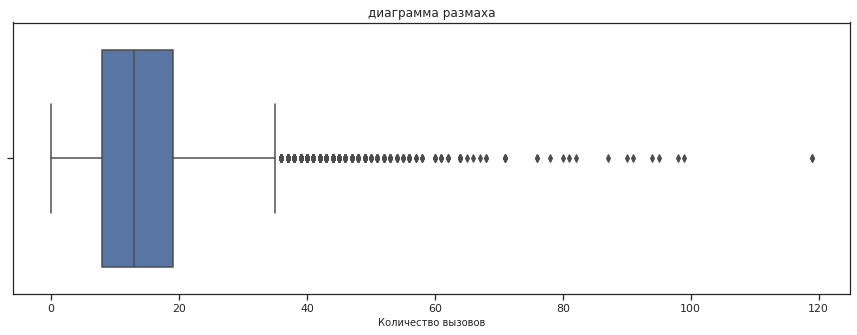

In [5]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='num_orders')
plt.title('диаграмма размаха', fontsize=12)
plt.xlabel('Количество вызовов', fontsize=10)

Есть 2 колонки значений с датами и количеством заказов, без пропущенных и без каких-то совсем невозможных значений.

In [6]:
df = df.resample("1H").sum()
print(df)

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]


## Анализ

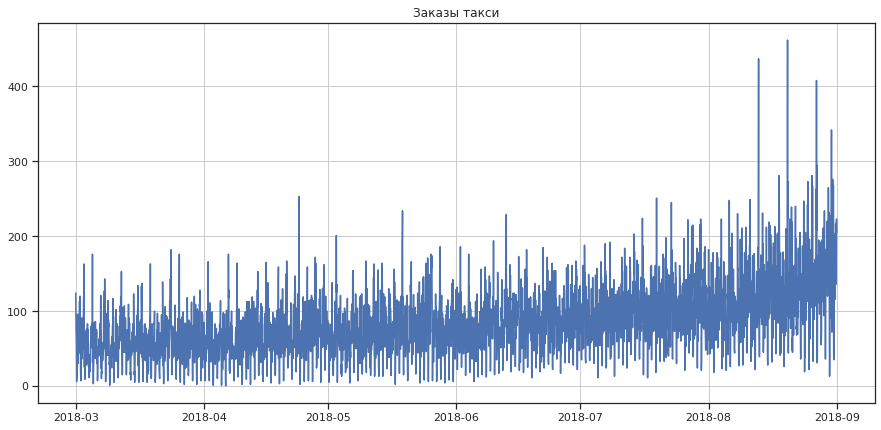

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(df.num_orders)
plt.title('Заказы такси')
plt.grid(True)
plt.show()

Проверим на стационарность временной ряд

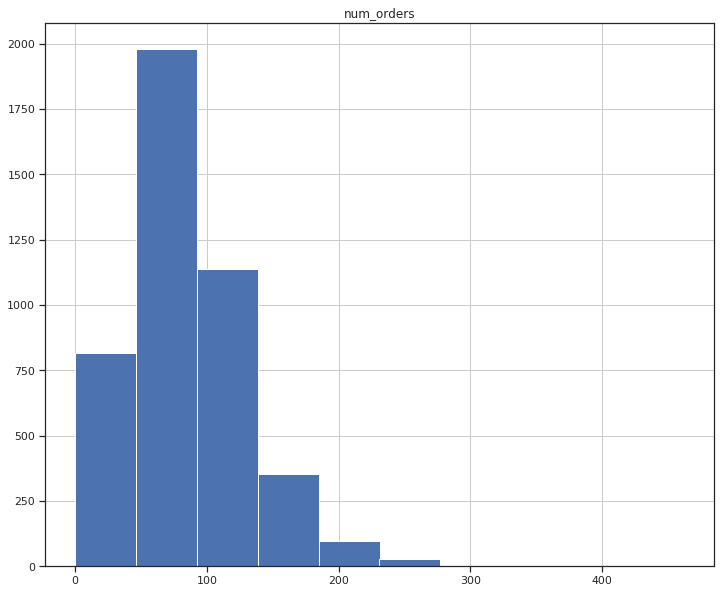

In [8]:
#from pandas import Series
#series = Series.from_csv('daily-total-female-births.csv', header=0)
df.hist()
pyplot.show()

In [9]:
X = df.num_orders
split = len(X) / 2
X1 = X[0:int(split)] 
X2 = X[int(split):]
#X1 = X[0:22]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=65.003170, mean2=103.842391
variance1=1082.371988, variance2=2218.256979


In [10]:
adfuller(df["num_orders"])

(-3.068924289027949,
 0.02894005140261345,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

Критическое значение = -3.06 < -2.86 при 5-% доверительном интервале. Временной ряд - стационарный.

display(decomposed.seasonal.head(50))
display(decomposed.trend.head(50))
display(decomposed.resid.head(50))

decompfreq=24
decomposed = sm.tsa.seasonal_decompose(decomposed.resid[100:])
sm.tsa.seasonal_decompose(df["num_orders"],freq=decompfreq).plot()
print(
    "Критерий Дики-Фуллера: p=%f"
    % sm.tsa.stattools.adfuller(df["num_orders"])[1]
)

Критерий Дики-Фуллера: p=0.000000


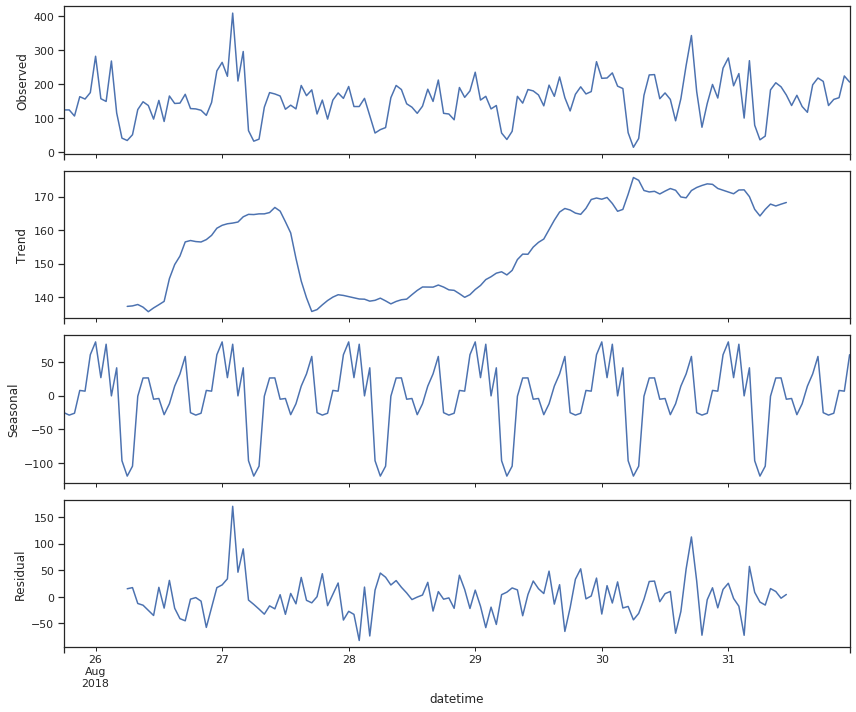

In [39]:
decompfreq=24
decomposed = sm.tsa.seasonal_decompose(df)
sm.tsa.seasonal_decompose(df["num_orders"][-150:],freq=decompfreq).plot()
print(
    "Критерий Дики-Фуллера: p=%f"
    % sm.tsa.stattools.adfuller(df["num_orders"][-150:])[1]
)

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

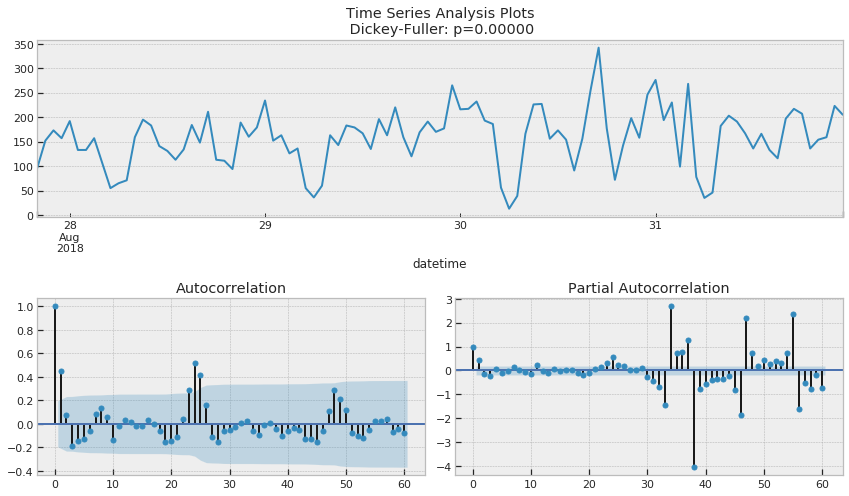

In [13]:
tsplot(df.num_orders[-100:], lags=60)

По автокорелляции видно повторение пиков на отметках 0, 24 и 48. Также видим сезонность на верхрнем графике.

Видно, что присутствует тренд. Избавимся от суточной сезонности.

df_resample["num_orders_diff"] = df_resample["num_orders"] - df_resample["num_orders"].shift(23,fill_value=0)

tsplot(df_resample.num_orders_diff[-100:], lags=60)

На автокорелляция видимая суточная сезонность ушла. Значимый временной лаг = 10.

In [14]:
df_resample_days = df.resample("1D").sum()

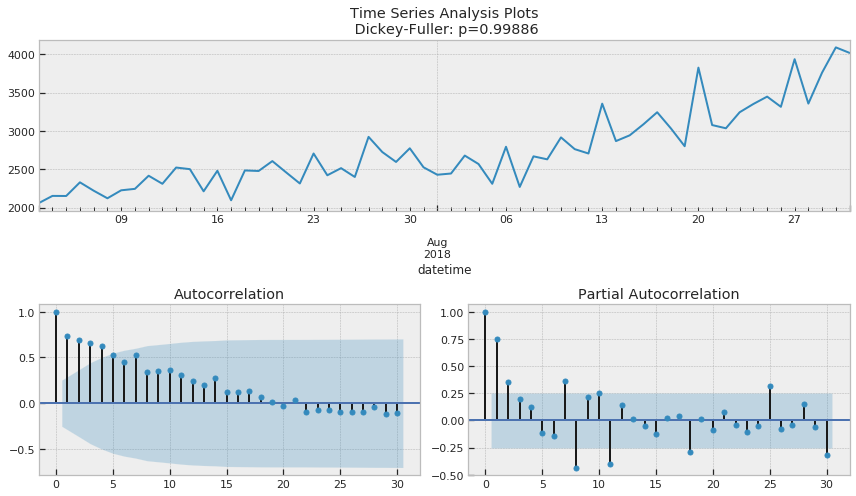

In [15]:
tsplot(df_resample_days.num_orders[-60:], lags=30)

Заметна цикличность пиков и низин через 7 дней (16, 23, 30, 6, 13, 20, 27)

20 августа 2018 года было понедельником. Т.е. по воскресеньем наблюдается снижение, а в по понедельникам всплеск.

df_resample["num_orders_diff2"] = df_resample["num_orders_diff"] - df_resample["num_orders_diff"].shift(24*7-1)

In [16]:
df_resample_days = df.resample("1D").sum()

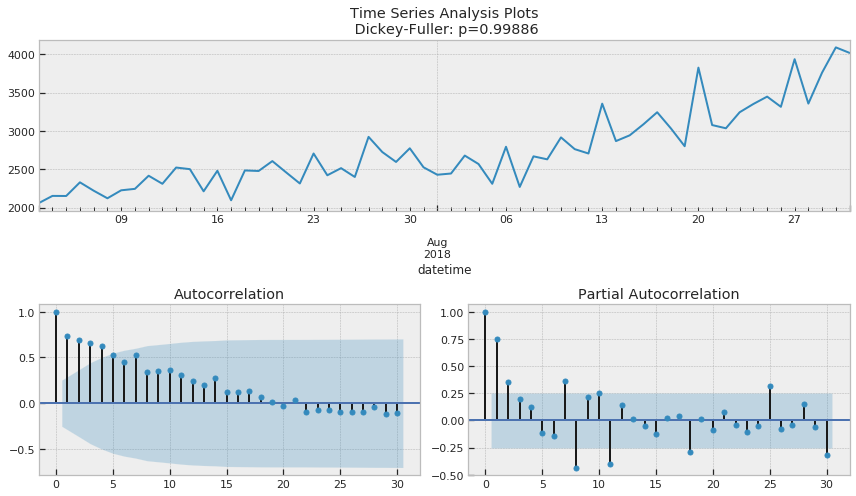

In [17]:
tsplot(df_resample_days.num_orders[-60:], lags=30)

<div class="alert alert-info">  Добавил просмотр сезонности на коротких периодах. Отделил суточную и недельную зависимость.  </div>

## Обучение

<div class="alert alert-info">  Добавил ниже сезонность и убрал часть лагов.  </div>

df_resample['season_day'] = df_resample["num_orders"].rolling(24).mean()
df_resample['season_week'] = df_resample["num_orders"].rolling(168).mean()
df_resample=df_resample[168:]

**************************

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 1,24)
df.shape

(4416, 6)

*************************

In [22]:
df=df[25:]
display(df)

,num_orders,hour,day,dayofweek,lag_1,rolling_mean
datetime,,,,,,
2018-03-02 01:00:00,120,1,2,4,90.0,55.416667
2018-03-02 02:00:00,75,2,2,4,120.0,56.875000
2018-03-02 03:00:00,64,3,2,4,75.0,57.041667
2018-03-02 04:00:00,20,4,2,4,64.0,56.958333
2018-03-02 05:00:00,11,5,2,4,20.0,56.000000
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,164.875000
2018-08-31 20:00:00,154,20,31,4,136.0,167.541667
2018-08-31 21:00:00,159,21,31,4,154.0,168.041667


In [23]:
df_TestModels = pd.DataFrame()

In [25]:
x = df.drop('num_orders', axis=1)
y = df['num_orders']
print(x.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.2, random_state=123)

(4391, 5) (4391,)


In [26]:
start_time = timeit.default_timer()
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}

split_index = TimeSeriesSplit().split(x_train)
param_set = [{'max_depth': range(20,60,5),'n_estimators': range(10,40,5),'max_features': ['sqrt', 'log2', None]}]  
grid = GridSearchCV(RandomForestRegressor(n_estimators=30), param_grid=param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=split_index, verbose=2)

grid.fit(x_train, y_train)
RMSE = np.sqrt(((grid.predict(x_test) - y_test) ** 2).mean())
print("RMSE: %.2f" % RMSE)
elapsed = timeit.default_timer() - start_time

tmp = pd.DataFrame([[model, elapsed, RMSE]])
df_TestModels = df_TestModels.append(tmp)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] max_depth=20, max_features=sqrt, n_estimators=10 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=10, total=   0.0s
[CV] max_depth=20, max_features=sqrt, n_estimators=10 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=10, total=   0.0s
[CV] max_depth=20, max_features=sqrt, n_estimators=10 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=10, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=15 ................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . max_depth=20, max_features=sqrt, n_estimators=15, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=15 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=15, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=15 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=15, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=20 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=20, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=20 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=20, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=20 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=20, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=25 ................
[CV] . max_depth=20, max_features=sqrt, n_estimators=25, total=   0.1s
[CV] max_depth=20, max_features=sqrt, n_estimators=25 ................
[CV] .

[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   51.6s finished


RMSE: 25.93


In [27]:
def predict_painer(y_test,predict_test):
    df_plot=pd.DataFrame(y_test)
    df_plot['predict_num_orders']=predict_test
    df_plot.sort_index(inplace=True)
    df_plot=pd.DataFrame(df_plot).tail(35)
    df_plot["num_orders"].plot()
    df_plot["predict_num_orders"].plot(color="r")
    plt.ylabel("orders");

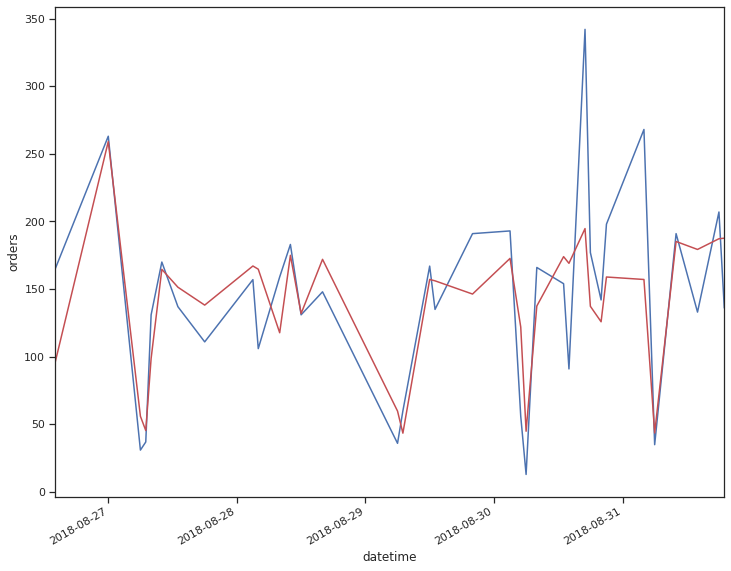

In [28]:
predict_painer(y_test,grid.predict(x_test) )

In [29]:
%%time
best_RMSE = 10000
best_n_estimators = 0
best_m_depth = 0
n_estimators = 6
max_depth = 9
for maxdepth in range(1, 16, 5):
    for nestimators in range(1, 100, 35):
        start_time = timeit.default_timer()
        model = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                    learning_rate=0.17, n_estimators=nestimators, max_depth=maxdepth,
                                    metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
        model.fit(x_train, y_train) 
        predict_test = model.predict(x_test)
        RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_n_estimators = n_estimators
            best_m_depth = max_depth
    print(model,': ',RMSE)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
print('best_RMSE =', RMSE,'best_n_estimators =', best_n_estimators,  'best_m_depth =', best_m_depth)
tmp = pd.DataFrame([[model, elapsed, RMSE]])
df_TestModels = df_TestModels.append(tmp)

LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.17, max_depth=1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=71, n_jobs=-1, num_leaves=1200,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.9, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0) :  29.383405843451687
0.11155332624912262
LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.17, max_depth=6,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=71, n_jobs=-1, num_leaves=1200,
              objective='regression', random_sta

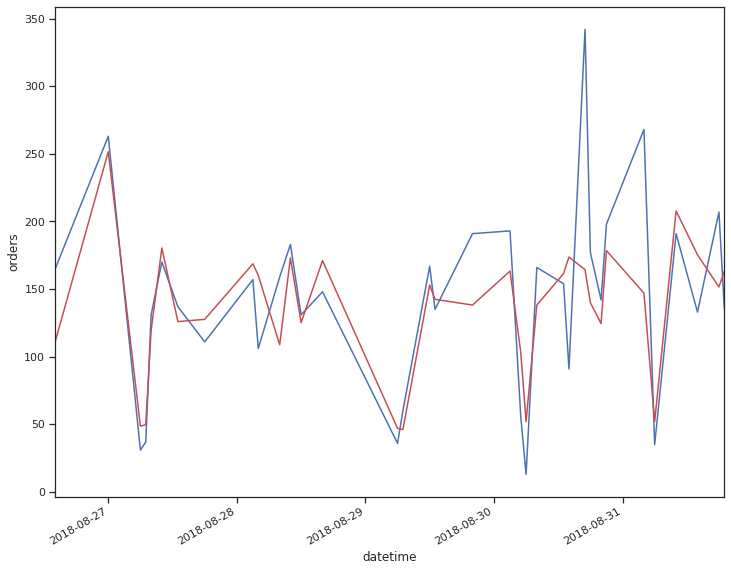

In [30]:
n_estimators = best_m_depth
max_depth = best_m_depth
start_time = timeit.default_timer()
model = LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                            learning_rate=0.17, n_estimators=nestimators, max_depth=maxdepth,
                            metric='rmse', bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
model.fit(x_train, y_train) 
predict_test = model.predict(x_test)
RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())

predict_painer(y_test,predict_test)

In [31]:
models=[SVR(kernel='linear'),DummyClassifier(strategy="most_frequent", random_state=12345)]
for model_parametr in models:
    start_time = timeit.default_timer()
    model.fit(x_train, y_train) 
    predict_test = model.predict(x_test)
    RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
    print(model,': ',RMSE)
    elapsed = timeit.default_timer() - start_time
    tmp = pd.DataFrame([[model, elapsed, RMSE]])
    df_TestModels = df_TestModels.append(tmp)

LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.17, max_depth=11,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=71, n_jobs=-1, num_leaves=1200,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.9, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0) :  24.757986624438082
LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.17, max_depth=11,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=71, n_jobs=-1, num_leaves=1200,
              objective='regression', random_state=None, reg_alpha

In [32]:
best_RMSE=10**5
best_elapsed=0
best_n_neighbor=0
for n_neighbor in range(1,10):
    start_time = timeit.default_timer()
    model = KNeighborsRegressor(n_neighbors=6)
    model.fit(x_train, y_train) 
    predict_test = model.predict(x_test)
    RMSE = np.sqrt(((predict_test - y_test) ** 2).mean())
    elapsed = timeit.default_timer() - start_time
    if RMSE<best_RMSE:
        best_n_neighbor=n_neighbor
        best_RMSE=RMSE
        best_elapsed=elapsed
tmp = pd.DataFrame([[n_neighbor, elapsed, RMSE]])
df_TestModels = df_TestModels.append(tmp)

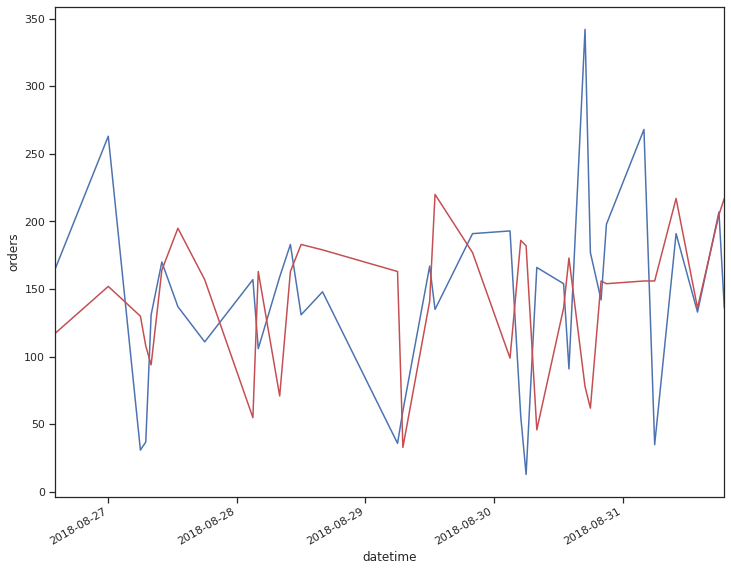

In [33]:
model = KNeighborsRegressor(n_neighbors=best_n_neighbor)
model.fit(x_train, y_train) 
predict_test = model.predict(x_test)

predict_painer(y_test,predict_test)

In [34]:
display(df_TestModels)

,0,1,2
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",52.072176,25.926129
0,"LGBMRegressor(bagging_fraction=0.8, boosting_t...",1.699997,24.757987
0,"LGBMRegressor(bagging_fraction=0.8, boosting_t...",1.529711,24.757987
0,"LGBMRegressor(bagging_fraction=0.8, boosting_t...",1.493000,24.757987
0,9,0.010283,34.458368


In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """ 
    results = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_resample.num_orders, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

CPU times: user 2h 5min 55s, sys: 27min 37s, total: 2h 33min 32s
Wall time: 2h 35min 2s

In [ ]:
result_table.head()

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_resample.num_orders, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [ ]:
model_fit = model.fit(x_train, y_train) 

predict_test = model_fit.predict(x_test)

predict_painer(y_test,predict_test)

## Тестирование

In [ ]:
display(df_TestModels)

Наименьший RMSE получили на модели линейной регрессии 26.77

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48